In [1]:
#!pip install ydata-profiling demoji nltk scikit-learn gensim  textblob spacy textstat transformers torch seaborn

In [2]:
import requests, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from ydata_profiling import ProfileReport
from textstat import flesch_reading_ease  # exploring text complixity
import nltk
from nltk.tokenize import word_tokenize
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# classification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, AdamW

from torch.nn.utils.rnn import pad_sequence

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
diplomacy= pd.read_json('data/all_data.jsonl', lines=True)
diplomacy.head(2)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1


In [4]:
token = '[SEP]' # the seperator token for BERT
conversations = []

for i, j in diplomacy.iterrows(): 
    players = j['players']
    if(len(j['messages']) == 0):
        print("Empty Row: " , i)
        continue
    message = '[CLS]'
    for c, d in enumerate(j['messages']):       
        if (j['speakers'][c] == players[0]):
            message += 'A:' + j['messages'][c] + token
        if (j['speakers'][c] == players[1]):    
             message += 'B:' + j['messages'][c] + token
                
    conversations.append(message)

df1 = pd.DataFrame({'conversation': conversations, 'A_bad_intent': 1 , 'B_bad_intent': 1})                     
df1.info()

Empty Row:  9
Empty Row:  62
Empty Row:  87
Empty Row:  96
Empty Row:  188
Empty Row:  249
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   conversation  246 non-null    object
 1   A_bad_intent  246 non-null    int64 
 2   B_bad_intent  246 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 5.9+ KB


In [5]:
df1.loc[0]['conversation']

'[CLS]A:Germany!\n\nJust the person I want to speak with. I have a somewhat crazy idea that I’ve always wanted to try with I/G, but I’ve never actually convinced the other guy to try it. And, what’s worse, it might make you suspicious of me. \n\nSo...do I suggest it?\n\nI’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? That’s my hope anyway.\n\nWhat is your appetite like for unusual and crazy?[SEP]B:You\'ve whet my appetite, Italy. What\'s the suggestion?[SEP]A:👍[SEP]B:It seems like there are a lot of ways that could go wrong...I don\'t see why France would see you approaching/taking Munich--while I do nothing about it--and not immediately feel skittish[SEP]A:Yeah, I can’t say I’ve tried it and it works, cause I’ve never tried it or seen it. But how I think it would work is (a) my Spring move looks like an attack on Austria, so it would not be surprising if you did not cover Munich. Then (b) you bu

In [6]:
good = pd.read_csv('data/full_dialog.csv')
good.head()

,Unnamed: 0,Unit,Turn,B4,B2
0,0,Good morning. How are you doing today?,0,0,20180904-045349_715_live
1,1,Hi. I am doing good. How about you?,0,1,20180904-045349_715_live
2,2,I'm doing pretty good for a Tuesday morning.,1,0,20180904-045349_715_live
3,3,"Haha. Same here, but it really feels like a Mo...",1,1,20180904-045349_715_live
4,4,Ugh yes it does!,2,0,20180904-045349_715_live


In [7]:
conversations = []
n =0

for i, j in good.iterrows(): 
    
    # This is a new conversation, append the prevoius conversation to the conversations list
    if j['Turn'] == 0 and n == 2 :
        conversations.append(conv)
        n=0
    # its the sencond turn=0 of each conversation
    if j['Turn'] == 0 and n == 1 :
        n =2
    # if its start of a new conversation including the very first one
    if j['Turn'] == 0 and n == 0 :
        conv = '[CLS]'
        # becouse there are two messages with turn=0 in each convrsation
        n =1
    if(j['B4'] == 0) :
        conv+= 'A:' + j['Unit'] + '[SEP]'
    elif (j['B4'] == 1):
        conv+= 'B:' + j['Unit'] + '[SEP]'  
      
df2 = pd.DataFrame({'conversation': conversations, 'A_bad_intent': 0, 'B_bad_intent': 0})                     
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   conversation  1016 non-null   object
 1   A_bad_intent  1016 non-null   int64 
 2   B_bad_intent  1016 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.9+ KB


In [8]:
df2.loc[0]['conversation']

"[CLS]A:Good morning. How are you doing today?[SEP]B:Hi. I am doing good. How about you?[SEP]A:I'm doing pretty good for a Tuesday morning. [SEP]B:Haha. Same here, but it really feels like a Monday.[SEP]A:Ugh yes it does![SEP]B:I can not believe how warm it is already.[SEP]A:Where are you from? [SEP]B:I am from the Midwest. What about you?[SEP]A:I'm from the South East. It's always warm here. [SEP]B:Oh, yep. You are definitely in for warm weather, which is great as far as I am concerned.[SEP]A:We're about to get hit by a tropical storm.[SEP]B:I heard that some bad weather was going to be coming. I hope it is not too severe.[SEP]A:Me too. It's just part of living on the Gulf. You have to be prepared for it.[SEP]B:Yes, I am sure you get a lot of storms.[SEP]A:We do. I guess I should get into what this chat is supposed to be about. Have you heard of the Charity Save The Children?[SEP]B:I have heard about them. What do you like about them?[SEP]A:I like that they're committed to helping chi

In [9]:
df = pd.concat([df1, df2], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   conversation  1262 non-null   object
 1   A_bad_intent  1262 non-null   int64 
 2   B_bad_intent  1262 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 29.7+ KB


In [10]:
df

,conversation,A_bad_intent,B_bad_intent
0,[CLS]A:Germany!\n\nJust the person I want to s...,1,1
1,[CLS]B:Hello there! What's your general plan f...,1,1
2,[CLS]B:Buongiorno! \nBe kinda nice to know if ...,1,1
3,[CLS]B:Hey italy! good luck this game. I'm gue...,1,1
4,[CLS]B:Hello Italy what’s up what are your tho...,1,1
...,...,...,...
1257,"[CLS]A:Good morning, how are you doing today?[...",0,0
1258,[CLS]A:hi[SEP]B:Hi how are you?[SEP]A:i'm fine...,0,0
1259,"[CLS]A:hi[SEP]B:Hello, how are you?[SEP]A:i am...",0,0
1260,[CLS]A:Hi there! How are you today?[SEP]B:I am...,0,0


---
### Preprocessing the combined dataset

In [11]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
df[df['conversation'] == '']

,conversation,A_bad_intent,B_bad_intent


In [13]:
def text_preprocess(message):
    processed = []   
    for text in message:
        # replaace URLs
        text = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",' <URL>',text)        
        # Remove HTML/XML tags (if any)
        text = re.sub(r'<.*?>', '', text)
        # Remove punctuation and symbols (not for now)
        # text = re.sub(r'[^\w\s]', '', text) 
        # Remove numbers - not in this dataset!
        #text = re.sub(r'\d+', '', text)
        # Remove whitespaces (including new lines and tabs)
        text = text.strip().replace("\n", " ").replace("\r", " ").replace("\t", " ")
        
        processed.append(text)       
    return processed

In [14]:
df['conversation'] = text_preprocess(list(df['conversation']))
df

,conversation,A_bad_intent,B_bad_intent
0,[CLS]A:Germany! Just the person I want to spe...,1,1
1,[CLS]B:Hello there! What's your general plan f...,1,1
2,[CLS]B:Buongiorno! Be kinda nice to know if y...,1,1
3,[CLS]B:Hey italy! good luck this game. I'm gue...,1,1
4,[CLS]B:Hello Italy what’s up what are your tho...,1,1
...,...,...,...
1257,"[CLS]A:Good morning, how are you doing today?[...",0,0
1258,[CLS]A:hi[SEP]B:Hi how are you?[SEP]A:i'm fine...,0,0
1259,"[CLS]A:hi[SEP]B:Hello, how are you?[SEP]A:i am...",0,0
1260,[CLS]A:Hi there! How are you today?[SEP]B:I am...,0,0


<Axes: >

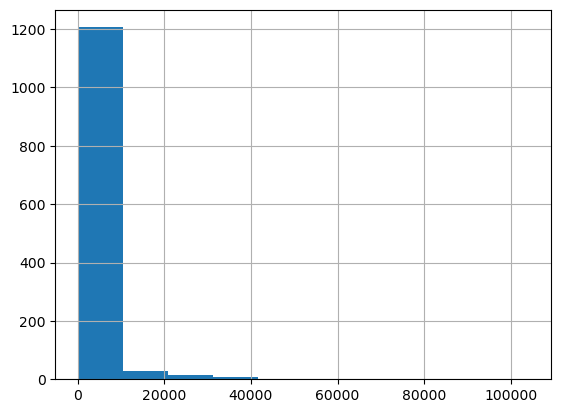

In [15]:
#number of characters in each conversation
df['conversation'].str.len().hist()

<Axes: >

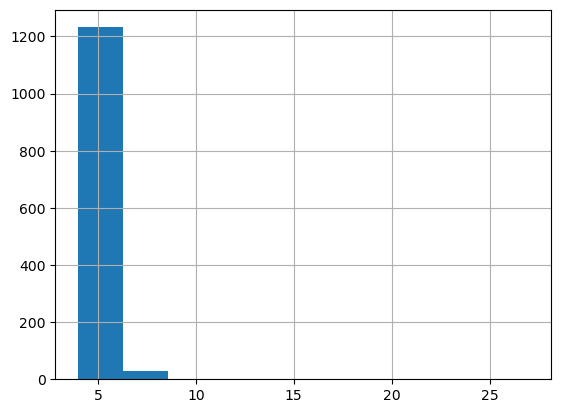

In [16]:
#  check the average word length
df['conversation'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()  

<Axes: >

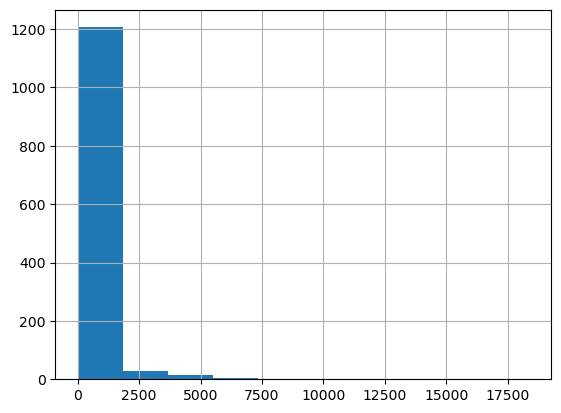

In [17]:
#  check the number of words in each message list
df['conversation'].str.split().apply(lambda x : len(x)).hist()  

In [18]:
# number of conversation wth more than 512 words
long_conversations = sum([1 if len(i.split()) > 512 else 0 for i in df['conversation']])
long_conversations

232

In [19]:
df['conversation'].str.split().apply(lambda x : len(x)).describe()

count     1262.000000
mean       529.881141
std       1017.760600
min          1.000000
25%        229.000000
50%        319.000000
75%        446.750000
max      18352.000000
Name: conversation, dtype: float64

In [20]:
df['conversation'].loc[0]

'[CLS]A:Germany!  Just the person I want to speak with. I have a somewhat crazy idea that I’ve always wanted to try with I/G, but I’ve never actually convinced the other guy to try it. And, what’s worse, it might make you suspicious of me.   So...do I suggest it?  I’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? That’s my hope anyway.  What is your appetite like for unusual and crazy?[SEP]B:You\'ve whet my appetite, Italy. What\'s the suggestion?[SEP]A:👍[SEP]B:It seems like there are a lot of ways that could go wrong...I don\'t see why France would see you approaching/taking Munich--while I do nothing about it--and not immediately feel skittish[SEP]A:Yeah, I can’t say I’ve tried it and it works, cause I’ve never tried it or seen it. But how I think it would work is (a) my Spring move looks like an attack on Austria, so it would not be surprising if you did not cover Munich. Then (b) you build two 

In [21]:
# flesch_reading_ease => 206.835 - 1.015 * (total_words / total_sentences) - 84.6 * (total_syllables / total_words)
text_ease = df['conversation'].apply(lambda x : [flesch_reading_ease(x) for i in x])


In [22]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#Noun (NN)
#Verb (VB)
#Adjective(JJ)
#Adverb(RB)
#Preposition (IN)
#Conjunction (CC)
#Pronoun(PRP)
#Interjection (INT)

# here i get all pos!
# the result of this function would be json which wont be really useful as a feature
def pos_tag_frequency(sentence):
    words = word_tokenize(sentence)
    pos_tags = nltk.pos_tag(words)
    #select the second element in each tuple
    tags = [tag for word, tag in pos_tags if tag == 'PRP']
    tag_freq = Counter(tags)
    return tag_freq

pron_freq = []
article_freq = []
prep_freq = []
adj_freq = []

for i, j in df.iterrows():       
    words = word_tokenize(j['conversation'])
    pos_tags = nltk.pos_tag(words)
    pron_freq.append(len([tag for word, tag in pos_tags if tag == 'PRP']))
    article_freq.append(sum([1 for word in words if word.lower() in ['the', 'a', 'an']]))
    prep_freq.append(len([tag for word, tag in pos_tags if tag == 'IN']))
    adj_freq.append(len([tag for word, tag in pos_tags if tag == 'JJ']))
    

[nltk_data] Downloading package punkt to /home/766619/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/766619/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


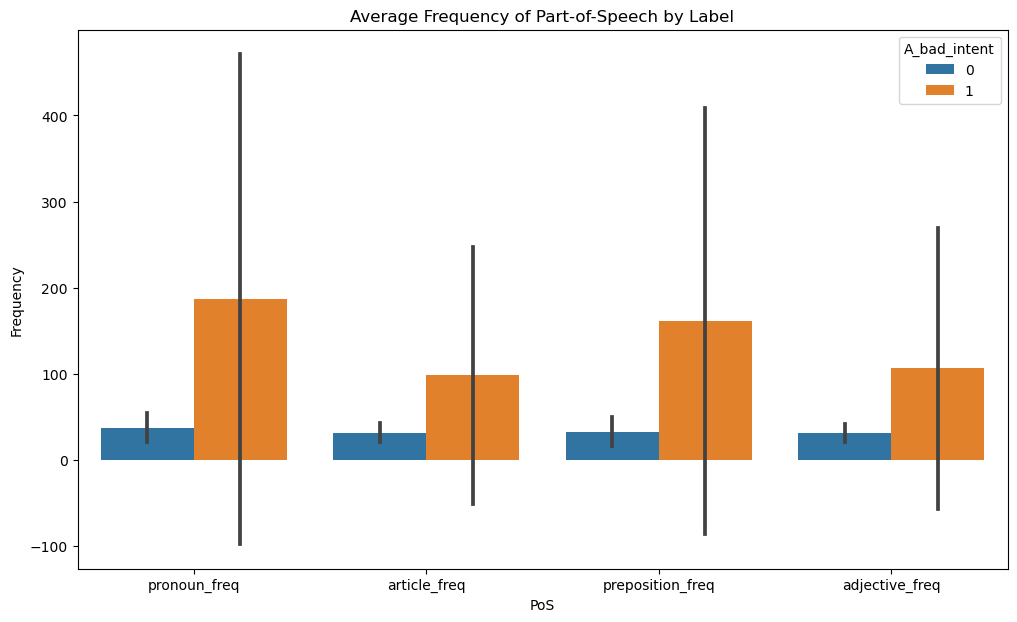

In [23]:
chart_df = pd.DataFrame()
chart_df['pronoun_freq'] = pron_freq
chart_df['article_freq'] = article_freq
chart_df['preposition_freq'] = prep_freq
chart_df['adjective_freq'] = adj_freq
chart_df['A_bad_intent'] = df['A_bad_intent']
chart_df['B_bad_intent'] = df['B_bad_intent']

df_melted = chart_df.melt(id_vars=['A_bad_intent' ,'B_bad_intent'], value_vars=['pronoun_freq', 'article_freq', 'preposition_freq', 'adjective_freq'], 
                    var_name='PoS', value_name='Frequency')

plt.figure(figsize=(12, 7))
sns.barplot(x='PoS', y='Frequency', hue='A_bad_intent', data=df_melted, ci='sd')
plt.title('Average Frequency of Part-of-Speech by Label')
plt.show()

In [24]:
num_samples = len(df)
# Calculate the average number of words per sample
num_words = df['conversation'].apply(lambda x: len(x.split()))
avg_words_per_sample = num_words.mean()

# Calculate the ratio
ratio = num_samples / avg_words_per_sample
ratio

2.381666193118093

---
### Preaper dataset for classification

<Axes: xlabel='A_bad_intent', ylabel='count'>

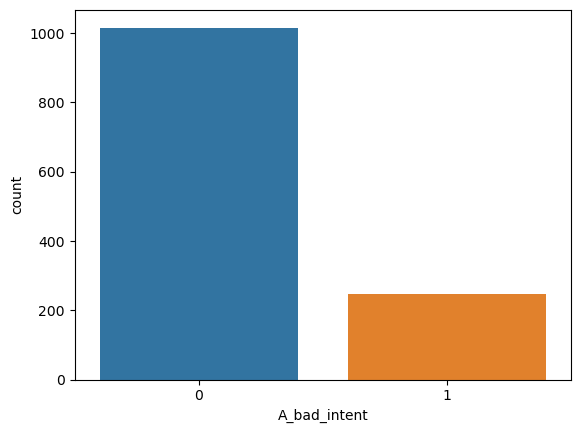

In [25]:
sns.countplot(data = df, x= df['A_bad_intent'])

<Axes: xlabel='B_bad_intent', ylabel='count'>

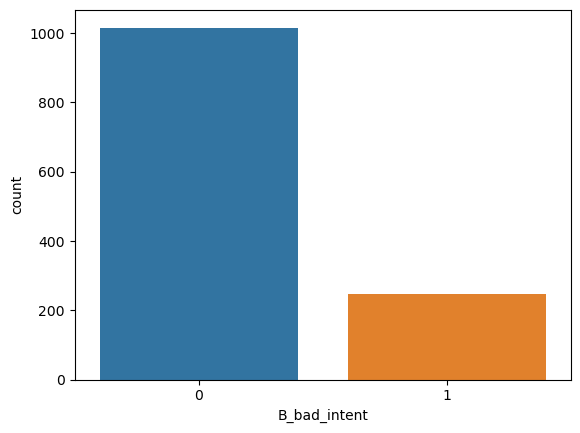

In [26]:
sns.countplot(data = df, x= df['B_bad_intent'])

#### balance the dataset or evalue the classification by weighted F1 score???

+ Normalization /scaling --> no need when using BERT
+ Shuffling --> shuffle=True in train_test_split


---
### Classification

In [27]:
# If there's a GPU available...
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU: NVIDIA A100 80GB PCIe MIG 2g.20gb


---
Classification Model, to label each actor in the conversation

In [28]:
#@todo use BertForSequenceClassification instead of BertModel?

class ParticipantClassifier(nn.Module):
    def __init__(self, bert_model_name):
        super(ParticipantClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        # add a linear layer that maps the hidden state to two outputs, labels
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
 
    # input_ids, attention_mask are ouputs of tokenizer
    def forward(self, input_ids, attention_mask):
        # pass the input to the model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # [CLS] token representation
        logits = self.classifier(pooled_output)
        # models confidence score for each calss
        logits_a = logits[:, 0]
        logits_b = logits[:, 1]
        return logits_a, logits_b

---
Tokenize and chunck conversations to segments with less than 512 tokens

In [29]:
class ConversationDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512, overlap=25): # overlap hardcoded
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.overlap = overlap
        
    def __len__(self):
        return len(self.data)
    
    def _tokenize(self, text):
        """Tokenize the text into overlapping segments."""
        tokens = self.tokenizer.encode(text, add_special_tokens=False)
        segments = []
        if len(tokens) > self.max_length - 2:  # for [CLS] and [SEP]
            start = 0
            while start < len(tokens):
                #end = start + self.max_length - 2
                end = min(start + self.max_length-2, len(tokens))
                segment = tokens[start:end]
                #segment = [self.tokenizer.cls_token_id] + segment + [self.tokenizer.sep_token_id] # do I need this?
                #pad chunks up to the max length
                #padded_segments = segments + [self.tokenizer.pad_token_id] * (self.max_length - len(segments))  # do I need this?
                segments.append(segment)              
                #start = end - self.overlap  
                # update the start and end of the next chunk
                start += self.max_length - self.overlap
       
        else:
            segments.append(tokens)
        return segments
    
    def __getitem__(self, idx):
        text = self.data[idx]['conversation']
        segments = self._tokenize(text)
        # process each segment
        inputs = [self.tokenizer.prepare_for_model(
                    seg,
                    add_special_tokens=False,  # I add special tokens manually
                    max_length=self.max_length,
                    padding='max_length',
                    return_tensors='pt',
                    truncation=True # 
                  ) for seg in segments]
        
        label_a = 1 if self.data[idx]['A_bad_intent'] == 1 else 0
        label_b = 1 if self.data[idx]['B_bad_intent'] == 1 else 0
        
        # return a list of segments, each with its own input_ids and attention_mask
        return {
            'segments': [{
                'input_ids': input['input_ids'].squeeze(),
                'attention_mask': input['attention_mask'].squeeze()
            } for input in inputs],
            'A_bad_intent': label_a,
            'B_bad_intent': label_b
        }

---

To ensure that each batch processed by the model has the same shape, collate_fn pads the sequences so that all data in a batch have the same length


In [30]:
def collate_fn(batch):
    """
    Custom collate function for handling batches of segmented conversations.
    """
    # lists to store the sequences and labels for all segments across all batch items
    input_ids_list = []
    attention_mask_list = []
    labels_a_list = []
    labels_b_list = []
 
    # list to store the segments for all batch items
    batch_segments = []
 
    for item in batch:
        # accumulate the labels for each item in the batch
        labels_a_list.append(item['A_bad_intent'])
        labels_b_list.append(item['B_bad_intent'])
 
        # collect segments from each item in the batch
        item_segments = []
        for segment in item['segments']:
            # for each segment, extract input_ids and attention_mask
            input_ids = segment['input_ids']
            attention_mask = segment['attention_mask']
 
            # append the segment's input_ids and attention_mask to the respective lists
            input_ids_list.append(input_ids)
            attention_mask_list.append(attention_mask)
 
            # also collect segments for this item
            item_segments.append({
                'input_ids': input_ids,
                'attention_mask': attention_mask
            })
 
        batch_segments.append(item_segments)
 
    # pad the sequences so that each sequence in the batch has the same length
    input_ids_padded = pad_sequence(input_ids_list, batch_first=True, padding_value=0)
    attention_mask_padded = pad_sequence(attention_mask_list, batch_first=True, padding_value=0)
    # convert labels lists to tensors
    labels_a = torch.tensor(labels_a_list)
    labels_b = torch.tensor(labels_b_list)
 
    # return the dictionary with padded 'input_ids', 'attention_mask' and 'segments'
    return {
        'segments': batch_segments,
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'A_bad_intent': labels_a,
        'B_bad_intent': labels_b
    }

---
To feed the text to BERT, first it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

In [31]:
#bert-base-uncased model has only lowercase letters!
# bert-base-cased: This model is case-sensitive: it makes a difference between english and English.
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False) 


In [32]:
#Train Test Validation split

# shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
 
# define split sizes
train_size = int(0.7 * len(df)) # reduced train data to 50% to resolve cuda out of memory problem
val_size = int(0.15 * len(df))
 
# split the DataFrame
train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]
 

In [33]:
train_data = train_df.to_dict('records')
val_data = val_df.to_dict('records')
test_data = test_df.to_dict('records')
#data
# Get the lists of sentences and their labels.
#data = df.conversation.values
#labels = df.target.values

In [34]:
# Print the original conversation.
print(' Original: ', train_data[300])
# Print that split into tokens.
tokenized_sample = tokenizer.tokenize(train_data[300]['conversation'])
print('Tokenized: ', tokenized_sample)
# Print mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenized_sample))

 Original:  {'conversation': "[CLS]A:Hi! Have you ever heard of Save the Children? It's a charity![SEP]B:yes I do[SEP]A:What do you think of it?[SEP]B:well, it is a charity work / organisation where they save many children [SEP]A:Yup! And it's an international group, and not owned/sponsored by any government.[SEP]B:you're right, it is non-profit organisation. [SEP]A:Have you ever considered donating to them?[SEP]B:it is an NGO, yes ofcourse many times I have considered to donate them as per my ability [SEP]A:Me too. And I just learned today that they have partnerships that match individual donation - so every amount a person givves is actually doubled. Did you know that?[SEP]B:aw, really ? No I haven't heard of it [SEP]A:Yes, I was really surprised too. And I learned that they focus on health first, but also prioritze education. I think that is important, as it will help the children grow up with a better chance of being successful. What do you think?[SEP]B:well, I'm glad to hear such 

In [35]:
# batch and suffle the data

train_dataset = ConversationDataset(train_data, tokenizer, max_length=512)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True ,collate_fn=collate_fn)

val_dataset = ConversationDataset(val_data, tokenizer, max_length=512)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

test_dataset = ConversationDataset(test_data, tokenizer, max_length=512)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [36]:
train_dataset[300]

Token indices sequence length is longer than the specified maximum sequence length for this model (616 > 512). Running this sequence through the model will result in indexing errors


{'segments': [{'input_ids': tensor([  101,   138,   131,  8790,   106,  4373,  1128,  1518,  1767,  1104,
           12596,  1103,  4288,   136,  1135,   112,   188,   170,  6630,   106,
             102,   139,   131,  4208,   146,  1202,   102,   138,   131,  1327,
            1202,  1128,  1341,  1104,  1122,   136,   102,   139,   131,  1218,
             117,  1122,  1110,   170,  6630,  1250,   120,  5632,  1187,  1152,
            3277,  1242,  1482,   102,   138,   131, 10684,  1643,   106,  1262,
            1122,   112,   188,  1126,  1835,  1372,   117,  1105,  1136,  2205,
             120,  5988,  1118,  1251,  1433,   119,   102,   139,   131,  1128,
             112,  1231,  1268,   117,  1122,  1110,  1664,   118,  5022,  5632,
             119,   102,   138,   131,  4373,  1128,  1518,  1737,  1274,  3798,
            1106,  1172,   136,   102,   139,   131,  1122,  1110,  1126, 23170,
             117,  4208,  1104, 16461,  1242,  1551,   146,  1138,  1737,  1106,
   

In [37]:
len(test_dataset.data)

316

In [ ]:
# sometime there is indices error when training, lets check if :
#Token indices sequence length is longer than the specified maximum sequence length for this model
for i, j in enumerate(train_dataset):
    for a, b in enumerate(train_dataset[i]['segments']):
        if len(train_dataset[i]['segments'][a]['input_ids']) > 512:
            print('in train dataset:')
            print(i,a, len(train_dataset[i]['segments'][a]['input_ids']))
        
for i, j in enumerate(val_dataset):
    for a, b in enumerate(val_dataset[i]['segments']):
        if len(val_dataset[i]['segments'][a]['input_ids']) > 512:
            print('in val dataset:')
            print(i, len(val_dataset[i]['segments'][a]['input_ids']))
        
for i, j in enumerate(test_dataset):
    for a, b in enumerate(test_dataset[i]['segments']):
        if len(test_dataset[i]['segments'][a]['input_ids']) > 512:
            print('in test dataset:')
            print(i, len(test_dataset[i]['segments'][a]['input_ids']))

In [38]:
def compute_metrics(model, dataloader, device):
    model.eval()  # put model in evaluation mode
    true_labels_a = []
    true_labels_b = []
    pred_labels_a = []
    pred_labels_b = []
 
    with torch.no_grad():  # no need to track gradients for evaluation
        for batch in dataloader:
            # initialize lists to store logits for all segments
            logits_a_list = []
            logits_b_list = []
            # aggregate logits for each segment in the batch
            for segments in batch['segments']:  # 'segments' is a list of dictionaries
                segment_logits_a = []
                segment_logits_b = []
                for segment in segments:
                    input_ids = segment['input_ids'].to(device)
                    attention_mask = segment['attention_mask'].to(device)
                    logits_a, logits_b = model(input_ids, attention_mask=attention_mask)
                    segment_logits_a.append(logits_a)
                    segment_logits_b.append(logits_b)
                # combine the logits from all segments for the current example
                logits_a = torch.mean(torch.stack(segment_logits_a), dim=0)
                logits_b = torch.mean(torch.stack(segment_logits_b), dim=0)
                logits_a_list.append(logits_a)
                logits_b_list.append(logits_b)
 
            # convert logits to probabilities and then to binary predictions
            probs_a = torch.sigmoid(torch.cat(logits_a_list)).cpu().numpy()
            probs_b = torch.sigmoid(torch.cat(logits_b_list)).cpu().numpy()
            preds_a = (probs_a > 0.5).astype(int)
            preds_b = (probs_b > 0.5).astype(int)
 
            # collect the true labels and predictions
            true_labels_a.extend(batch['A_bad_intent'].numpy())
            true_labels_b.extend(batch['B_bad_intent'].numpy())
            pred_labels_a.extend(preds_a)
            pred_labels_b.extend(preds_b)
 
    # weighted F1 scores becouse dataset is imbalanced
    f1_a = f1_score(true_labels_a, pred_labels_a, average='weighted')
    f1_b = f1_score(true_labels_b, pred_labels_b, average='weighted')
 
    return {
        'f1_a': f1_a,
        'f1_b': f1_b
    }

In [39]:
def evaluate_model(model, dataloader, device, loss_function):
    model.eval()  # put model in evaluation mode
    total_val_loss = 0
 
    with torch.no_grad():  # no need to track gradients for evaluation
        for batch in dataloader:
            labels_a = batch['A_bad_intent'].to(device).float().view(-1, 1)
            labels_b = batch['B_bad_intent'].to(device).float().view(-1, 1)
            # lists to store outputs for all segments
            logits_a_accumulated = []
            logits_b_accumulated = []
 
            for segments in batch['segments']:  # now 'segments' is a list of dictionaries
                logits_a_list = []
                logits_b_list = []
                for segment in segments:
                    input_ids = segment['input_ids'].to(device)
                    attention_mask = segment['attention_mask'].to(device)
                    logits_a, logits_b = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
                    logits_a_list.append(logits_a)
                    logits_b_list.append(logits_b)
 
                logits_a_item = torch.mean(torch.stack(logits_a_list), dim=0)
                logits_b_item = torch.mean(torch.stack(logits_b_list), dim=0)
                logits_a_accumulated.append(logits_a_item)
                logits_b_accumulated.append(logits_b_item)
 
            logits_a = torch.cat(logits_a_accumulated, dim=0)
            logits_b = torch.cat(logits_b_accumulated, dim=0)
 
            loss_a = loss_function(logits_a.view(-1, 1), labels_a)
            loss_b = loss_function(logits_b.view(-1, 1), labels_b)
            loss = (loss_a + loss_b) / 2  # combine the losses
            total_val_loss += loss.item()  # Accumulate the total validation loss
 
    avg_val_loss = total_val_loss / len(dataloader)
    val_metrics = compute_metrics(model, dataloader, device)
    return avg_val_loss, val_metrics

In [40]:
accumulation_steps = 4  # should be adjust to  fit within avaialable memory limits
def train_model(model, dataloader, device, loss_function):
    model.train()  # set the model to training mode
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()  # zero the parameter gradients
        
         # labels need to be of float type and reshaped to be of the same size as output logits
        labels_a = batch['A_bad_intent'].to(device).float().view(-1, 1)
        labels_b = batch['B_bad_intent'].to(device).float().view(-1, 1)
        # initialize variables to accumulate the logits for all segments
        logits_a_accumulated = []
        logits_b_accumulated = []
        
        # loop over all items in the batch       
        for segments in batch['segments']:  # now 'segments' is a list of dictionaries
            # initialize lists to store outputs for all segments of this item
            logits_a_list = []
            logits_b_list = []
            
            # loop over all segments for this item
            for segment in segments:
                # segment is a dictionary as expected
                input_ids = segment['input_ids'].to(device)
                attention_mask = segment['attention_mask'].to(device)
               
                #print(f"Input IDs shape: {segment['input_ids'].shape}")
                #print(f"Attention Mask shape: {segment['attention_mask'].shape}")
                
                # forward pass for this segment
                logits_a, logits_b = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
                
                #print('Model output:', logits_a, logits_b)
                
                logits_a_list.append(logits_a)
                logits_b_list.append(logits_b)
                
            # aggregate the results for all segments of this item
            # here we use the mean of the logits, but you can choose other methods like max
            logits_a_item = torch.mean(torch.stack(logits_a_list), dim=0)
            logits_b_item = torch.mean(torch.stack(logits_b_list), dim=0)
            
            # Accumulate the logits for all items
            logits_a_accumulated.append(logits_a_item)
            logits_b_accumulated.append(logits_b_item)
            
        # Combine the accumulated logits for the whole batch
        logits_a = torch.cat(logits_a_accumulated, dim=0)
        logits_b = torch.cat(logits_b_accumulated, dim=0)

        # compute loss for both outputs
        loss_a = loss_function(logits_a.view(-1, 1), labels_a)
        loss_b = loss_function(logits_b.view(-1, 1), labels_b)
        loss = (loss_a + loss_b) / 2  # combine the losses
        
        loss = loss / accumulation_steps  # Normalize our loss (if averaged)
        
        # backward pass and optimize
        loss.backward()
        
        #optimizer.step()
        #perform optimization every 'accumulation_steps' iterations
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        

In [41]:
train_dataset.max_length

512

In [42]:
torch.cuda.empty_cache()

In [43]:
# Model & Optimizer
model = ParticipantClassifier('bert-base-cased')
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8) # eps: a very small number to prevent any division by zero
loss_function = nn.BCEWithLogitsLoss()

In [44]:
train_dataloader.batch_size

4

In [45]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:    
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:    
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [46]:
#@todo check oov words

In [47]:
#@todo improve metrics calculation -- check overfitting

In [48]:
#@todo plot validation training f1_score

In [49]:
device

device(type='cuda')

In [50]:
model = model.to(device)

In [51]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=128'

In [52]:
for epoch in range(3):  # 3 epochs?
    
    print('Training ...')
    train_model(model, train_dataloader, device, loss_function)
    
    print('Validation ...')
    avg_val_loss, val_metrics = evaluate_model(model, val_dataloader, device, loss_function)
    print(f'Validation Loss after epoch {epoch}: {avg_val_loss}')
    print(f'Validation Metrics after epoch {epoch}: {val_metrics}')
 
    print('Test ...')
    metrics = compute_metrics(model, test_dataloader, device)
    print(metrics)

Training ...


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 19.50 GiB total capacity; 18.58 GiB already allocated; 3.94 MiB free; 18.60 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
#gives a readable summary of memory allocation and allows to figure the reason of CUDA running out of memory
print(torch.cuda.memory_summary(device=None, abbreviated=False))